<a href="https://colab.research.google.com/github/RafalUzarowicz/IUM/blob/master/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
===


Zadanie biznesowe: 

*Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybyśmy wiedzieli, ile taka dostawa dla danego zamówienia potrwa – moglibyśmy przekazywać tą informację klientom.*

Zadanie modelowania:

Zadanie regregresji - przewidzieć czas dostawy zamówienia. Kryteria oceny modelu mogą być takie jak zazwyczaj dla regresji np. MSE, lub absolute mean error. Dodatkowo można zamiast jednego czasu dostawy przewidywać okno dostawy o założonej szerokości np. 2h i zastosować własną, niestandardową funkcję celu, która traktuje wszystkie dostawy, które wpadły w okienko jako przewidziane poprawnie.

In [1]:
import pandas as pd



In [ ]:
data_dir ="/content/drive/MyDrive/Data/IUM/"

deliveries = pd.read_json(data_dir + "deliveries.jsonl", lines=True)
sessions = pd.read_json(data_dir + "sessions.jsonl", lines=True)
users = pd.read_json(data_dir + "users.jsonl", lines=True)
products = pd.read_json(data_dir + "products.jsonl", lines=True)

data = {"products": products, "sessions": sessions, "users": users, "deliveries":deliveries}

In [ ]:
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-21T12:09:40,2021-02-22T15:06:21.051360,620.0
1,20002,2021-02-17T15:08:51,2021-02-21T12:16:54.977640,360.0
2,20003,2021-01-22T14:41:01,2021-01-22T15:19:19.040428,516.0
3,20004,2021-01-15T12:41:14,2021-01-13T22:45:05.607434,516.0
4,20005,2021-01-14T02:50:19,2021-01-14T11:35:28.612753,516.0


Eksploracyjna analiza danych 
======

In [ ]:
print(deliveries.shape, sessions.shape, users.shape, products.shape)
print(deliveries.columns, "\n", sessions.columns,"\n", users.columns,"\n", products.columns)

(6993, 4) (37690, 7) (200, 4) (319, 4)
Index(['purchase_id', 'purchase_timestamp', 'delivery_timestamp',
       'delivery_company'],
      dtype='object') 
 Index(['session_id', 'timestamp', 'user_id', 'product_id', 'event_type',
       'offered_discount', 'purchase_id'],
      dtype='object') 
 Index(['user_id', 'name', 'city', 'street'], dtype='object') 
 Index(['product_id', 'product_name', 'category_path', 'price'], dtype='object')


Ilościowo danych wydaje się być dostatecznie dużo, w najbardziej interesującej nas tabeli (deliveries) jest niemal 7 tysięcy wierszy, co powinno być dość zarówno do wytrenowania, walidacji jak i testowania modelu. 


In [ ]:
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-21T12:09:40,2021-02-22T15:06:21.051360,620.0
1,20002,2021-02-17T15:08:51,2021-02-21T12:16:54.977640,360.0
2,20003,2021-01-22T14:41:01,2021-01-22T15:19:19.040428,516.0
3,20004,2021-01-15T12:41:14,2021-01-13T22:45:05.607434,516.0
4,20005,2021-01-14T02:50:19,2021-01-14T11:35:28.612753,516.0


In [ ]:
sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-02-21 12:00:09,102.0,NaN,VIEW_PRODUCT,0,NaN
1,100001,2021-02-21 12:05:06,102.0,1319.0,VIEW_PRODUCT,0,NaN
2,100001,2021-02-21 12:07:17,102.0,1317.0,VIEW_PRODUCT,0,NaN
3,100001,2021-02-21 12:09:40,102.0,1317.0,BUY_PRODUCT,0,20001.0
4,100002,2021-02-17 15:08:42,102.0,1278.0,VIEW_PRODUCT,0,NaN


In [ ]:
users.head()

,user_id,name,city,street
0,102,Daniel Lenarcik,Konin,ul. Ceglana 28/79
1,103,Ernest Kusik,Konin,al. Zakole 710
2,104,Łukasz Fąferek,Konin,plac Kolonia 19
3,105,Grzegorz Wisz,Kutno,pl. Pomorska 20/90
4,106,Olaf Pacyga,Radom,ul. Dębowa 06/04


In [ ]:
products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


Omówienie kolumn
----

**Dane które na pewno będą istotne:**
- adres użytkownika (może być konieczne dodanie do niego kolumny z kodem pocztowym - powinno dać to lepsze pojęcie o położeniu punktów dostaw w tym samym rejonie, dalszym przetworzeniem może być też odległość absolutna pomiędzy magazynem/miejscem wysyłki a celem)
- dane dt. czasu złożenia zamówienia (prawdopodobnie trzeba będzie je przekszałcić w format bardziej nadający się do obróbki)
- dane dt. czasu dostawy (atrybut którego wartość będziemy próbowali przewidzieć wprost tj. datę lub pośrednio tj. czas między złożeniem zamówienia, a dostawą)
- dane dt. firmy kurierskiej (firma prawdopodobnie będzie mocno wpływać na czas dostawy)

**Dane które by się przydały:**
- dane dt. momentu i miejsca wysyłki produktów (czy zawsze wysyłane są z tego samego miejsca, czy istnieją jakieś opóźnienia)
- dane dt. punktów pośrednich na drodze przesyłki (o ile istnieją) np. punktów spedycyjnych, magazynów, to potencjalnie mogłoby pozwolić na ulepszanie predykcji w trakcie podróży przesyłki i im bliżej celu, tym dokładniejsze dane można by było zaprezentować użytkownikowi
- 

**Pozostałe dane:**

- session_id - raczej nieistotne 
-	timestamp z tabeli sessions - też raczej nieistotny, podobne informacje niesie timestamp zakupu produktu z tabeli deliveries, gdyż nie obchodzi nas jakie produkty przeglądał użytkownik, a tylko akcje kupna
- user_id - samo w sobie raczej nie niesie wartości, choć może być przydatne do łączenia z innymi tablicami (np. deliveries)
- product_id 	- przydatne do łączenia
- event_type 	- raczej nieistotne
- offered_discount 	- raczej nieistotne
- purchase_id - istotne do łączenia
- name 	- samo w sobie nieważne, można by z niego wyciągnąć takie dane jak np. płeć, jednak nie będzie to miało wpływu na czas dostawy
- product_name - raczej nie istotne
- category_path - może być o tyle ważne, że pewne produkty mogłyby być gabarytami, wtedy ich czas dostawy mógłby się znacznie różnic przez konieczność specjalnego ich traktowania
- price - cena sama w sobie raczej nie niesie wartości


**Ogólny komentarz**

Tabela deliveries - ważna, niesie istotne dane, choć może być konieczność poddania ich odpowiedniemu przetworzeniu przed utworzeniem modelu. Zawarte w niej daty i godziny są prawdopodobnie bardzo ważne w budowie modelu, ale będą wymagały przetworzenia - np. wyciągnięcia oddzielnie miesiąca, dnia, godziny, może też dnia tygodnia. 

Tabela sessions - raczej nieważna, choć spodziewam się że może nieść nieco istotnych danych nt. obciążenia systemu w poszczególnych okresach, co prawdopodobnie wpływa na czas dostaw. 
:owe użytkowników. 

Tabela products - przy wstępnej analizie nie wydaje się istotna, ale może da się na jej podstawie utworzyć nowe atrybuty bardziej przydatne dla problemu. Być może warto np. dodać do kolumny deliveries kolumnę zliczającą ile przedmiotów jest w jednym zamówieniu - wielkość zamówienia może wpływać na możliwości firm kurierskich co do czasu dostawy.


In [ ]:
for key in data.keys():
  print(key, ":\n", data[key].isnull().sum(), "\n")

products :
 product_id       0
product_name     0
category_path    0
price            0
dtype: int64 

sessions :
 session_id              0
timestamp               0
user_id              1915
product_id           1913
event_type              0
offered_discount        0
purchase_id         30697
dtype: int64 

users :
 user_id    0
name       0
city       0
street     0
dtype: int64 

deliveries :
 purchase_id             0
purchase_timestamp      0
delivery_timestamp    333
delivery_company      329
dtype: int64 



Brakujące dane w tabeli deliveries są raczej martwiące, dobrze by było jakby dało się je uzupełnić, jednak jeśli nie będzie to możliwe to pozostałe dane powinny być wystarczające do wytrenowania modelu (max 662 wiersze są wybrakowane, to poniżej 10% danych)

Cieszy brak pustych wartości w tabelach dotyczących użytkowników - nie powinno być problemu z nieznanymi adresami dostaw.

Braki w tabeli sessions nie zaskakują - wynikają prawdopodobnie ze sposobu jaki są gromadzone dane, np. puste wartości w kolumnie purchase_id wynikają najpewniej z tego że dany wiersz odpowiada wartości event_type innej niż BUY_PRODUCT

In [ ]:
categories = set()
for value in products["category_path"]:
  categories.update(value.split(";"))

categories

{'Akcesoria telefoniczne',
 'Anteny RTV',
 'Audio',
 'Biurowe urządzenia wielofunkcyjne',
 'Drukarki i skanery',
 'Gry PlayStation3',
 'Gry Xbox 360',
 'Gry i konsole',
 'Gry komputerowe',
 'Gry na konsole',
 'Komputery',
 'Monitory',
 'Monitory LCD',
 'Odtwarzacze DVD',
 'Odtwarzacze mp3 i mp4',
 'Okulary 3D',
 'Przenośne audio i video',
 'Sprzęt RTV',
 'Słuchawki',
 'Tablety',
 'Tablety i akcesoria',
 'Telefony i akcesoria',
 'Telefony komórkowe',
 'Telefony stacjonarne',
 'Telewizory i akcesoria',
 'Video',
 'Zestawy głośnomówiące',
 'Zestawy słuchawkowe'}

Po przyjrzeniu się kategoriom można zauważyć, że gabaryty sprzedawanych przedmiotów nie będą się bardzo różnić - choć transport monitorów LCD i Słuchawek jest różny, to raczej nie dość różny by wpłynąć na czas dostawy. Mimo to można dodać kolumnę dzielącą przedmioty na większe np. Drukarki i skaner, Komputery, Monitory i Monitory LCD jako urządzenia "duże", a telefony komorkowe, zestawy słuchawkowe i gry na konsole jako "małe". 

Feature engineering
-----

Dane czasowe - zamienić na czas absolutny, policzyć kolumnę czasu dostawy, pokazać dane na grafie i sprawdzić jakie są w nich trendy.

Adres - kod pocztowy, odległość absolutna

In [ ]:
deliveries.head()


,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-21T12:09:40,2021-02-22T15:06:21.051360,620.0
1,20002,2021-02-17T15:08:51,2021-02-21T12:16:54.977640,360.0
2,20003,2021-01-22T14:41:01,2021-01-22T15:19:19.040428,516.0
3,20004,2021-01-15T12:41:14,2021-01-13T22:45:05.607434,516.0
4,20005,2021-01-14T02:50:19,2021-01-14T11:35:28.612753,516.0


In [ ]:
deliveries["purchase_timestamp"] = pd.to_datetime ( deliveries["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
deliveries['delivery_timestamp'] = pd.to_datetime ( deliveries["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0
3,20004,2021-01-15 12:41:14,2021-01-13 22:45:05.607434,516.0
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0


In [ ]:
deliveries["time_difference"] = deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0,1 days 02:56:41.051360
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0,3 days 21:08:03.977640
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0,0 days 00:38:18.040428
3,20004,2021-01-15 12:41:14,2021-01-13 22:45:05.607434,516.0,-2 days +10:03:51.607434
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0,0 days 08:45:09.612753


In [ ]:
len(deliveries[deliveries["purchase_timestamp"] > deliveries["delivery_timestamp"]])

2064

Ujemne wartości w nowoutworzonej kolumnie wskazują na to, że dane są zanieczyszczone - produkt nie mógł być dostarczony przed zakupem. Takich zanieczyszczeń jest stosunkowo wiele - 2 tysiące wierszy, które przez to nie będą mogły zostać wykorzystane w modelowaniu. To zbyt wiele danych, żebyśmy mogli je po prostu pominąć, jak w przypadku brakujących czasów dostawy. 

In [ ]:
deliveries[deliveries["purchase_timestamp"] > deliveries["delivery_timestamp"]]

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference
3,20004,2021-01-15 12:41:14,2021-01-13 22:45:05.607434,516.0,-2 days +10:03:51.607434
12,20013,2021-03-10 20:54:25,2021-03-08 18:44:44.993229,516.0,-3 days +21:50:19.993229
24,20025,2021-02-15 09:58:52,2021-02-13 00:16:50.381008,360.0,-3 days +14:17:58.381008
29,20030,2021-01-30 08:02:24,2021-01-29 10:57:39.292954,360.0,-1 days +02:55:15.292954
34,20035,2021-03-12 21:20:24,2021-03-10 11:09:53.776848,620.0,-3 days +13:49:29.776848
...,...,...,...,...,...
6973,26974,2021-02-15 11:44:29,2021-02-15 00:28:42.002261,620.0,-1 days +12:44:13.002261
6974,26975,2021-01-29 20:49:03,2021-01-27 20:05:11.558722,360.0,-3 days +23:16:08.558722
6977,26978,2021-02-27 07:00:37,2021-02-25 12:43:34.486762,620.0,-2 days +05:42:57.486762
6982,26983,2021-01-21 14:11:09,2021-01-19 05:09:48.570606,516.0,-3 days +14:58:39.570606


In [ ]:
deliveries.dtypes

purchase_id                     int64
purchase_timestamp     datetime64[ns]
delivery_timestamp     datetime64[ns]
delivery_company              float64
time_difference       timedelta64[ns]
dtype: object

In [ ]:
preped = deliveries[deliveries["purchase_timestamp"] < deliveries["delivery_timestamp"]].copy()

In [ ]:
def to_seconds (time_delta):
  return time_delta.seconds
preped["time[s]"]=preped["time_difference"].apply(to_seconds)
preped.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s]
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0,1 days 02:56:41.051360,10601
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0,3 days 21:08:03.977640,76083
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0,0 days 00:38:18.040428,2298
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0,0 days 08:45:09.612753,31509
5,20006,2021-02-16 08:27:14,2021-02-19 09:58:54.243499,620.0,3 days 01:31:40.243499,5500


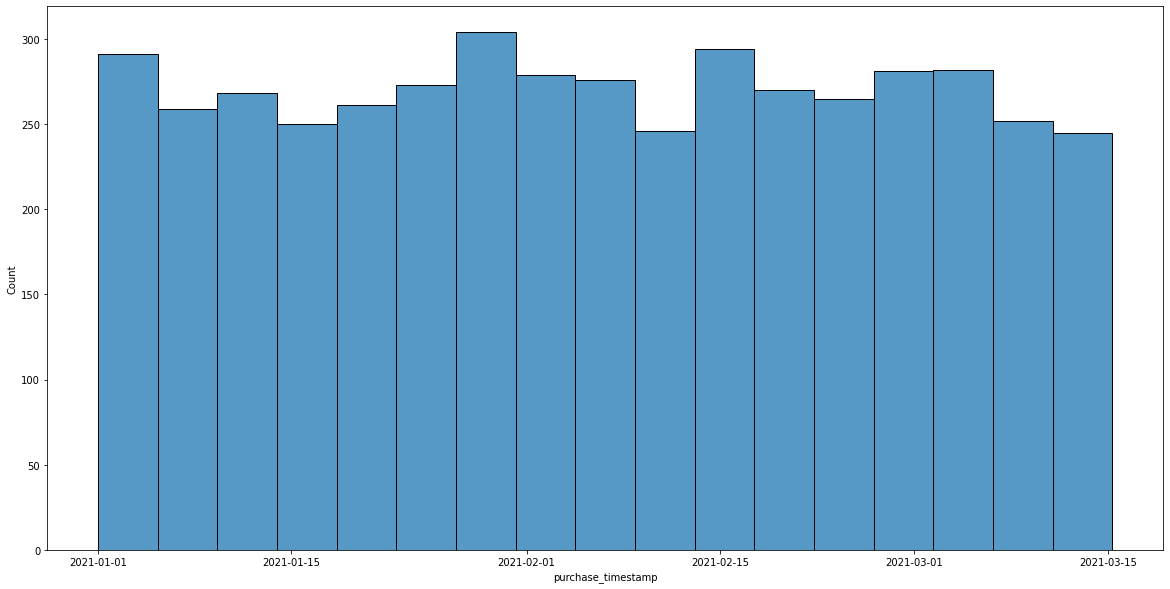

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def to_day(timestamp)


plt.figure(figsize=(20,10))
sns.histplot(preped["purchase_timestamp"])

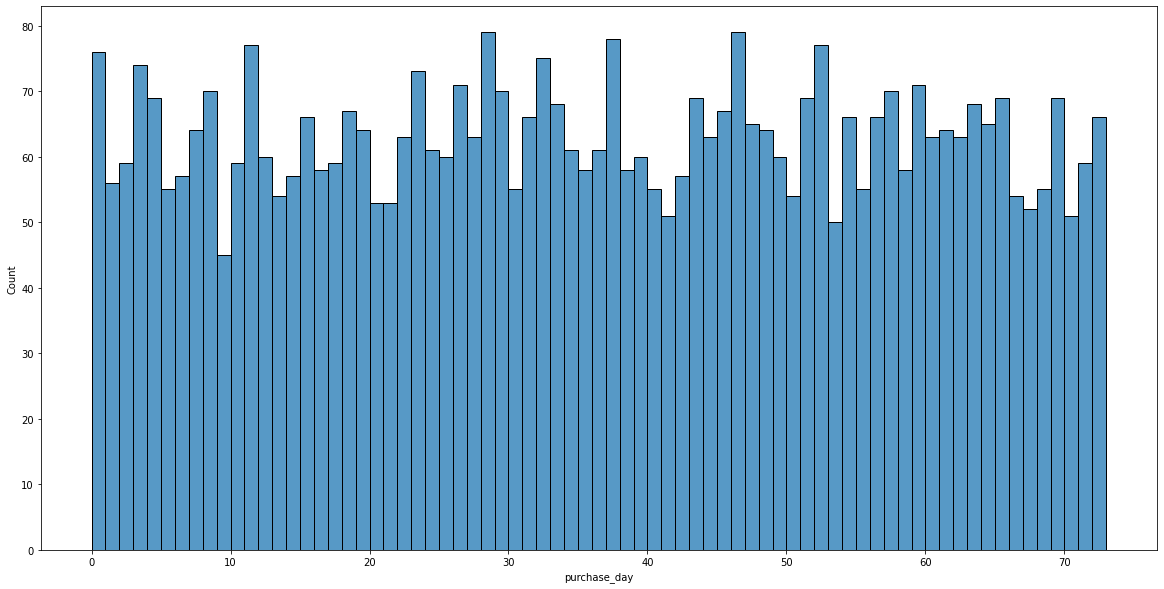

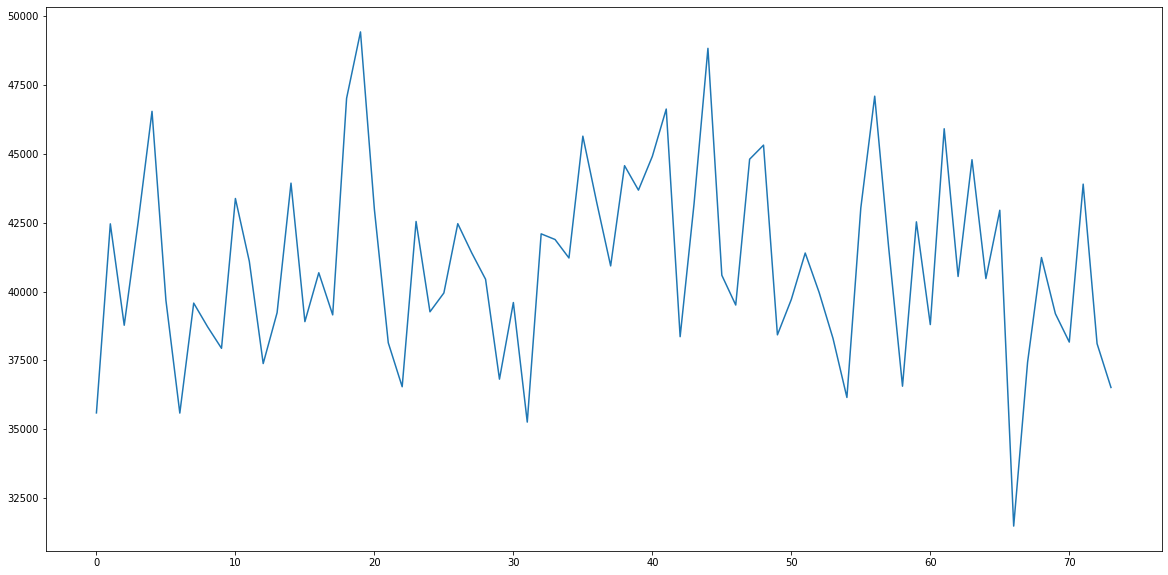

In [ ]:
import numpy as np
#map purchase timestamp to days for distplot
min_time = np.min(preped["purchase_timestamp"])
preped["purchase_day"] = preped["purchase_timestamp"].apply(lambda x: (x - min_time).days)
#preped.head()
plt.figure(figsize=(20,10))
sns.histplot(preped["purchase_day"], binwidth=1)
plt.show()

#average time by day?
plt.figure(figsize=(20,10))
days = preped["purchase_day"].unique()
avg_time_by_day = [np.average(preped[preped["purchase_day"]==day]["time[s]"]) for day in days]

sns.lineplot(x=days, y=avg_time_by_day)

plt.show()

Wydaje się, że dodanie dnia tygodnia jak nowego atrybutu może być przydatne do regresji

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


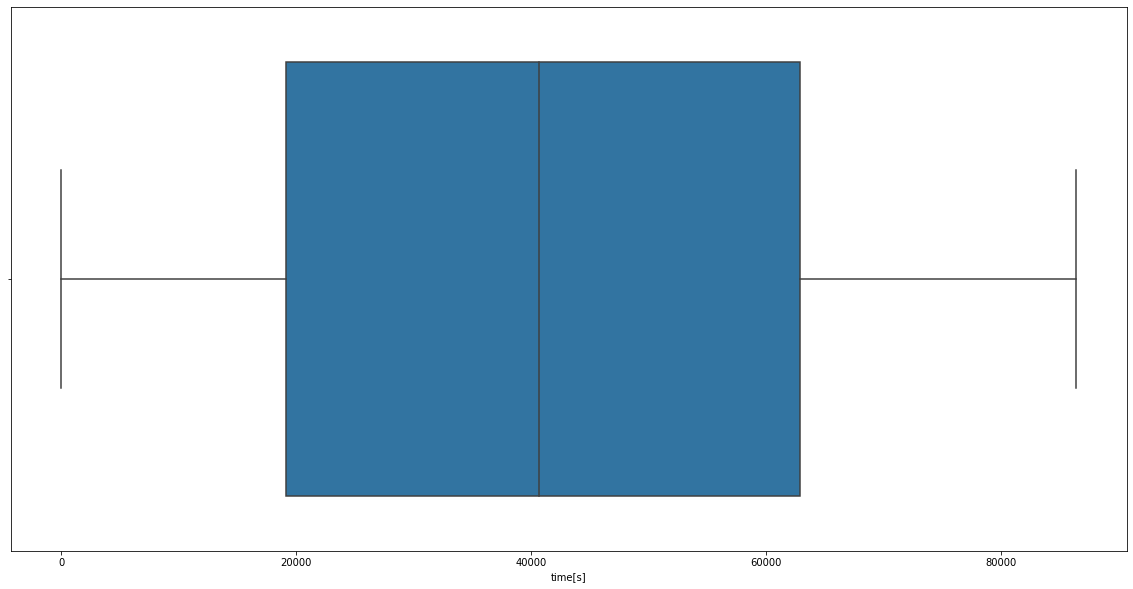

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(preped["time[s]"])

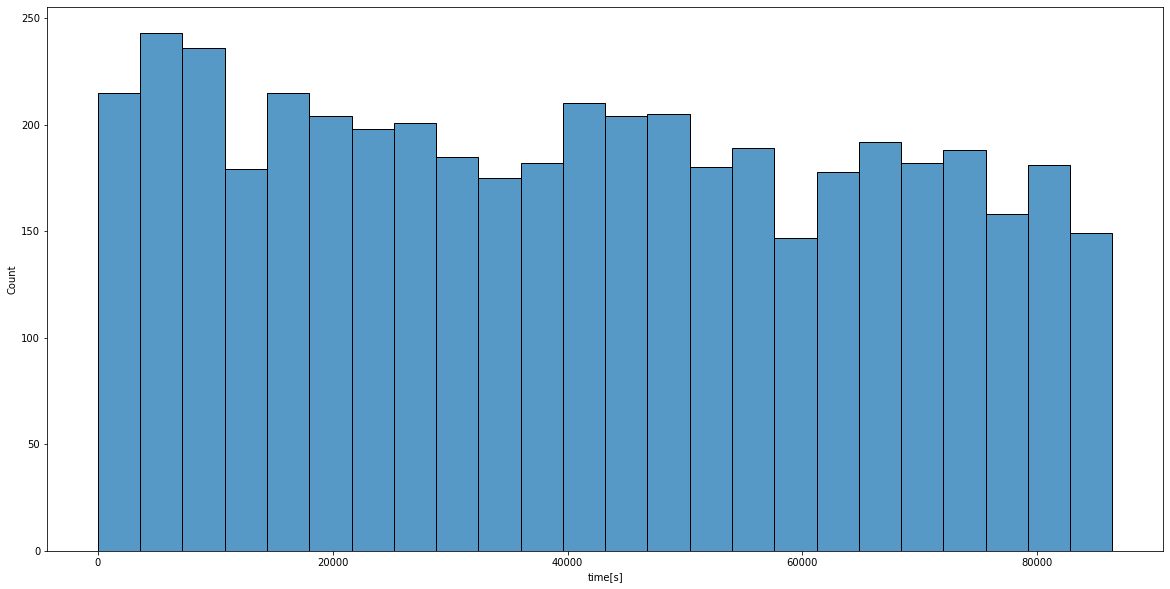

In [ ]:
plt.figure(figsize=(20,10))
sns.histplot(data=preped["time[s]"], binwidth=60*60)

In [ ]:
preped["time[h]"]=preped["time_difference"].apply(lambda x: x.seconds/(60*60))
preped.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],purchase_day,time[h]
0,20001,2021-02-21 12:09:40,2021-02-22 15:06:21.051360,620.0,1 days 02:56:41.051360,10601,51,2.944722
1,20002,2021-02-17 15:08:51,2021-02-21 12:16:54.977640,360.0,3 days 21:08:03.977640,76083,47,21.134167
2,20003,2021-01-22 14:41:01,2021-01-22 15:19:19.040428,516.0,0 days 00:38:18.040428,2298,21,0.638333
4,20005,2021-01-14 02:50:19,2021-01-14 11:35:28.612753,516.0,0 days 08:45:09.612753,31509,13,8.752500
5,20006,2021-02-16 08:27:14,2021-02-19 09:58:54.243499,620.0,3 days 01:31:40.243499,5500,46,1.527778


Na pierwszy rzut oka martwiące są czasy dostawy poniżej godziny, ale także te krótkie - 2 lub 3 - godzinne. Obecnym standardem w e-commerce jest dostawa przesyłki w ciągu 1-2 dni roboczych, czyli czas dostawy od mniej więcej 10 do 30-kilku godzin. Być może te krótkie dane są poprawne jeśli firma realizuje dostawy ekspresowe (np z usuługą dostawy tego samego dnia) albo np. możlwość odbioru towaru z salonu, jeśli jest on w nim dostępny. 

Mimo to dane nt. czasu dostawy wymagają dokładniejszego przyjrzenia się ich rozkładowi. 

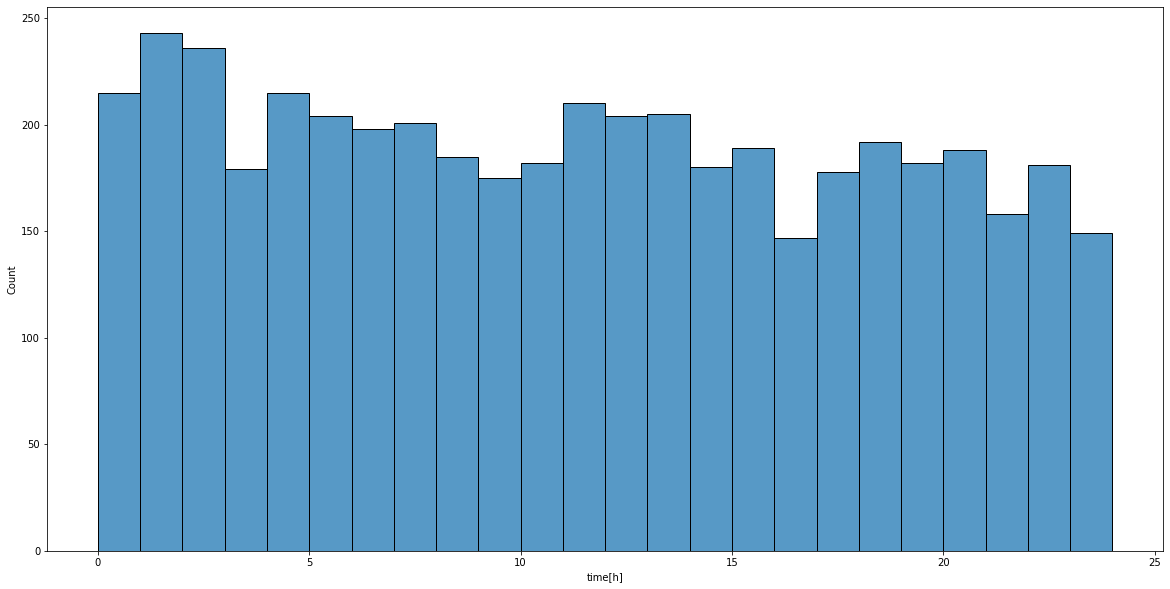

In [ ]:
plt.figure(figsize=(20,10))
sns.histplot(preped["time[h]"], binwidth=1)

Firma ewidentnie realizuje dostawy w przeciągu 24h, czyli raczej krótko. Podejrzanie krótkie czasy dostawy (poniżej 5 godzin) zdecydowanie wymagają wyjaśnienia z przedstawicielem firmy. 

Warto jeszcze sprawdzić jak wygląda rozkład czasu dostawy w godzinach w podziale na poszczególne firmy kurierskie - być może okaże się, że krótkie dostawy są realizowane tylko przez jedną firmę, co wskazywałoby na prawidłowość hipotezy o możliwości wykupienia ekspresowej dostawy. 

Ponadto warto też przyjrzeć się godzinom w jakich realizowana jest dostawa - mam podejrzenie, że znajdziemy tam jakieś dostawy w nieprzyzwoicie nocnych godzinach.

In [ ]:
preped["delivery_company"].unique()

array([620., 360., 516.,  nan])

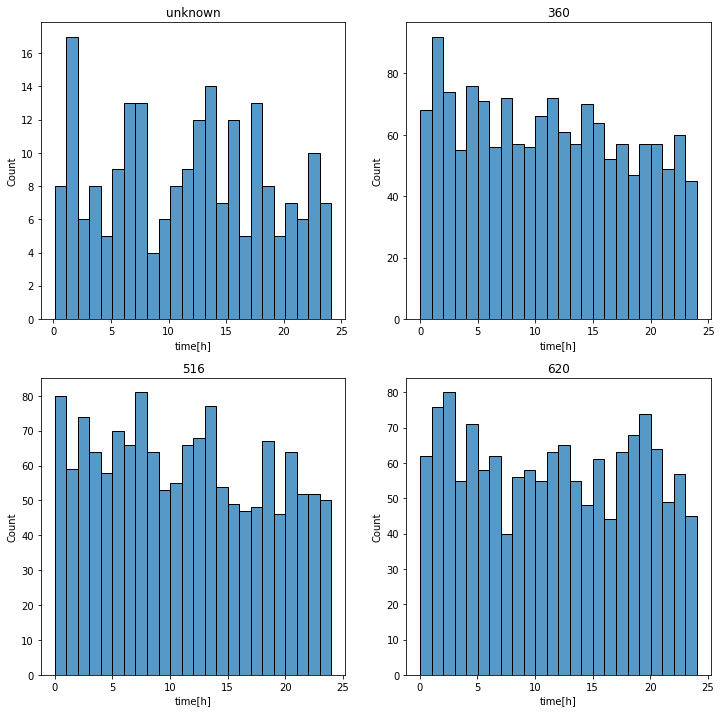

In [ ]:
 companies = preped["delivery_company"].unique()
 dfs = {}

dfs["unknown"] = preped[preped['delivery_company'].isna()]["time[h]"]
dfs["360"] = preped[preped['delivery_company']==360]["time[h]"]
dfs["516"] = preped[preped['delivery_company']==516]["time[h]"]
dfs["620"] = preped[preped['delivery_company']==620]["time[h]"]

fgs, axes = plt.subplots(2, 2, figsize=(12,12))
axs = [axes[i][j] for i in [0,1] for j in [0,1]]
i=0
for key, df in dfs.items():
  sns.histplot(data = df, binwidth=1, ax = axs[i])
  axs[i].title.set_text(key)
  i+=1
plt.show()


Nie wydaje się, żeby któraś z firm kurierskich dostarczała paczki znacznie szybciej od innych, co wskazuje raczej na błąd w pomiarach i nierzetelne dane. Podobnie nieprzekraczalny termin 24h też jest podejrzany - paczki z reguły są dostarczane w dni robocze (czasem również w soboty), więc dziwi że dla zamówień złożonych w soboty nie widzimy czasu powyżej 24h. 

In [ ]:
dataframe = pd.DataFrame({"purchase":preped["purchase_timestamp"].to_list(), "id": preped["purchase_id"].to_list()}, index=pd.DatetimeIndex(preped["delivery_timestamp"]))
dataframe.head()

,purchase,id
delivery_timestamp,,
2021-02-22 15:06:21.051360,2021-02-21 12:09:40,20001
2021-02-21 12:16:54.977640,2021-02-17 15:08:51,20002
2021-01-22 15:19:19.040428,2021-01-22 14:41:01,20003
2021-01-14 11:35:28.612753,2021-01-14 02:50:19,20005
2021-02-19 09:58:54.243499,2021-02-16 08:27:14,20006


In [ ]:
night_deliveries = dataframe.between_time("22:00", "6:00")
print(len(night_deliveries),night_deliveries)

1568                                       purchase     id
delivery_timestamp                                   
2021-01-11 04:55:15.205274 2021-01-10 19:17:36  20012
2021-01-20 22:33:22.398019 2021-01-18 21:16:10  20014
2021-01-07 04:43:12.039676 2021-01-04 02:42:37  20017
2021-02-18 22:39:12.233561 2021-02-17 21:46:48  20019
2021-03-15 04:55:43.633913 2021-03-14 03:52:29  20022
...                                        ...    ...
2021-03-06 03:15:20.787949 2021-03-05 20:30:30  26936
2021-01-08 02:08:35.492514 2021-01-07 22:22:13  26937
2021-01-05 04:03:11.860674 2021-01-03 21:25:45  26941
2021-02-23 04:02:47.767588 2021-02-20 09:56:28  26942
2021-01-10 23:35:58.426335 2021-01-09 04:53:47  26984

[1568 rows x 2 columns]


Nie wiem kto odbiera lub dostarcza dostawy po nocy, ale nasza firma najwyraźniej tak..... 

In [ ]:
users.head()

,user_id,name,city,street
0,102,Daniel Lenarcik,Konin,ul. Ceglana 28/79
1,103,Ernest Kusik,Konin,al. Zakole 710
2,104,Łukasz Fąferek,Konin,plac Kolonia 19
3,105,Grzegorz Wisz,Kutno,pl. Pomorska 20/90
4,106,Olaf Pacyga,Radom,ul. Dębowa 06/04


In [ ]:
users["city"].unique()

array(['Konin', 'Kutno', 'Radom', 'Police', 'Szczecin', 'Warszawa',
       'Gdynia', 'Mielec'], dtype=object)

New Data Analysis
====

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
data_dir ="/content/drive/MyDrive/Data/IUM/V2/"

deliveries = pd.read_json(data_dir + "deliveries.jsonl", lines=True)
sessions = pd.read_json(data_dir + "sessions.jsonl", lines=True)
users = pd.read_json(data_dir + "users.jsonl", lines=True)
products = pd.read_json(data_dir + "products.jsonl", lines=True)

data_v2 = {"products": products, "sessions": sessions, "users": users, "deliveries":deliveries}

deliveries["purchase_timestamp"] = pd.to_datetime ( deliveries["purchase_timestamp"], format='%Y-%m-%dT%H:%M', errors="coerce")
deliveries['delivery_timestamp'] = pd.to_datetime ( deliveries["delivery_timestamp"], format='%Y-%m-%dT%H:%M:%S', errors="coerce")
deliveries["time_difference"] = deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]

deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference
0,20001,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0 days 22:13:47.432964
1,20002,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,1 days 08:19:04.707128
2,20003,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,1 days 10:31:50.635371
3,20004,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620,0 days 22:52:48.608746
4,20005,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,1 days 23:41:36.973167


Sprawdzenie poprzednich problemów i analiza kompletności w pełni połączonych danych
----


0


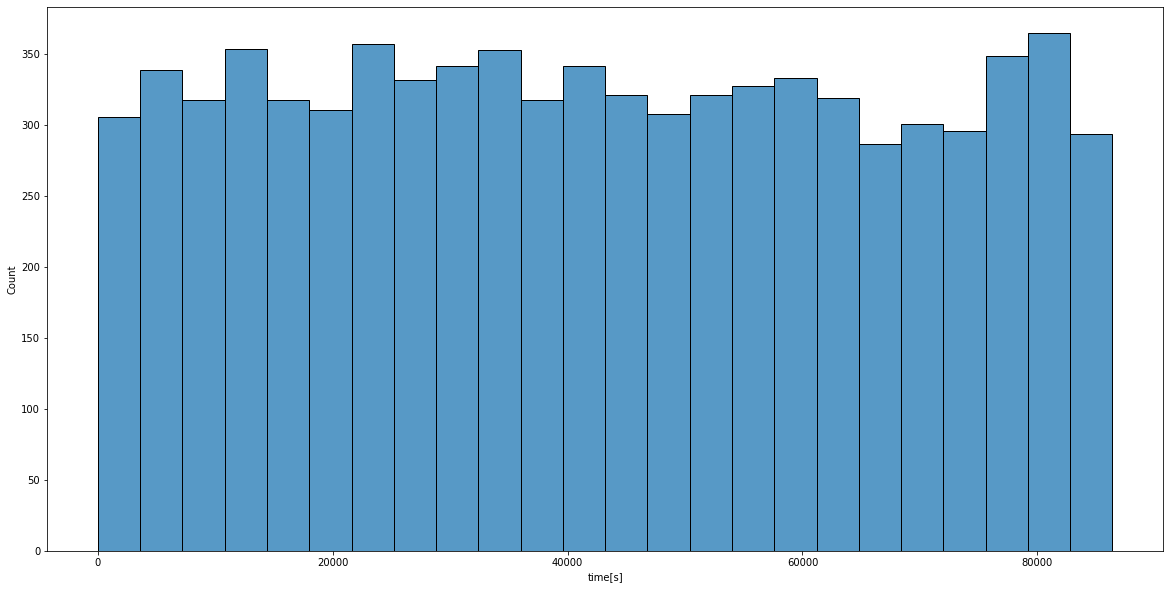

In [14]:
print("Num delivered before bought: ", len(deliveries[deliveries["purchase_timestamp"] > deliveries["delivery_timestamp"]]))

def to_seconds (time_delta):
  return time_delta.seconds
deliveries["time[s]"]=deliveries["time_difference"].apply(to_seconds)

plt.figure(figsize=(20,10))
sns.histplot(data=deliveries["time[s]"], binwidth=60*60)

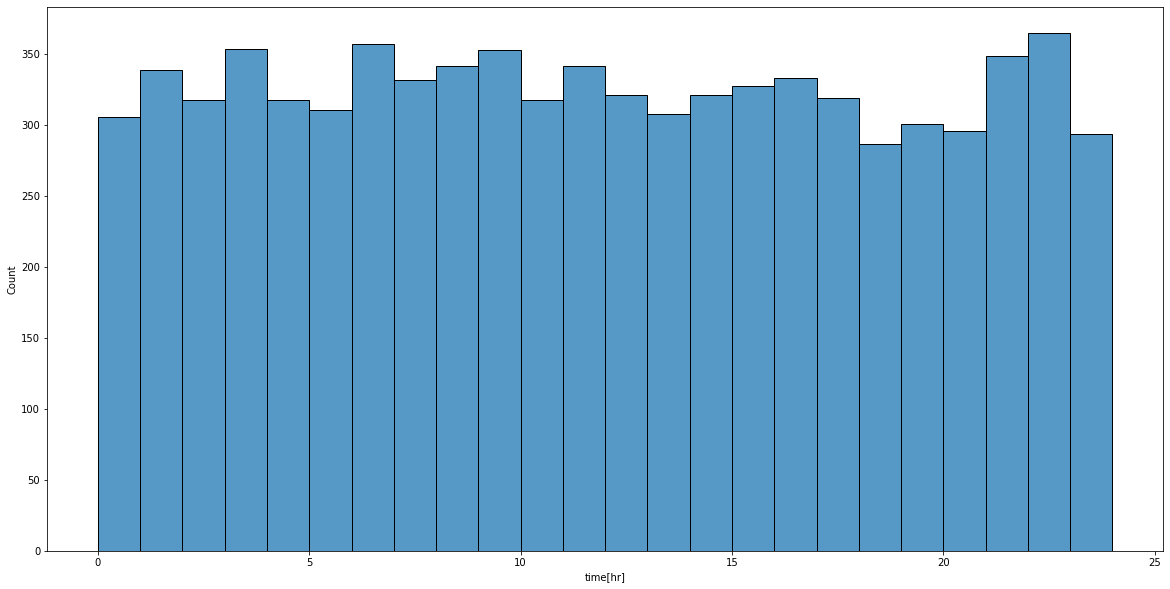

In [16]:
deliveries["time[hr]"]=deliveries["time[s]"].apply(lambda x: x/(60*60))

plt.figure(figsize=(20,10))
sns.histplot(data=deliveries["time[hr]"], binwidth=1)

W nowych danych czas dostawy wciąż jest lekko podejrzany - wiele produktów jest dostarczanych w ciągu godziny.... Jest ich 306, czyli wciąż sporo. 

In [18]:
very_quick = deliveries[deliveries["time[hr]"]<1]



len(very_quick)
deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],time[hr]
0,20001,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0 days 22:13:47.432964,80027,22.229722
1,20002,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,1 days 08:19:04.707128,29944,8.317778
2,20003,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,1 days 10:31:50.635371,37910,10.530556
3,20004,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620,0 days 22:52:48.608746,82368,22.880000
4,20005,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,1 days 23:41:36.973167,85296,23.693333


In [22]:
sessions_purchases = sessions[sessions["purchase_id"].notnull()].copy()
print(sessions_purchases.shape, deliveries.shape)

(7812, 7) (7812, 7)


In [32]:
sessions_purchases.sort_values("purchase_id", axis=0, inplace=True)
deliveries.sort_values("purchase_id", axis=0, inplace=True)

merged = pd.merge(sessions_purchases, deliveries, on='purchase_id', how = "outer")
print(deliveries.shape, sessions_purchases.shape, merged.shape) #sanity check

print(merged.isnull().sum())
merged.head()

(7812, 7) (7812, 7) (7812, 13)
session_id              0
timestamp               0
user_id               402
product_id            384
event_type              0
offered_discount        0
purchase_id             0
purchase_timestamp      0
delivery_timestamp      0
delivery_company        0
time_difference         0
time[s]                 0
time[hr]                0
dtype: int64


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],time[hr]
0,100002,2021-04-01 15:52:47,102.0,1234.0,BUY_PRODUCT,0,20001.0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0 days 22:13:47.432964,80027,22.229722
1,100003,2021-04-01 02:26:23,102.0,1289.0,BUY_PRODUCT,15,20002.0,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,1 days 08:19:04.707128,29944,8.317778
2,100004,2021-01-03 05:11:17,102.0,1009.0,BUY_PRODUCT,0,20003.0,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,1 days 10:31:50.635371,37910,10.530556
3,100005,2021-02-17 12:59:54,NaN,1001.0,BUY_PRODUCT,5,20004.0,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620,0 days 22:52:48.608746,82368,22.880000
4,100006,2021-02-13 09:17:52,102.0,1057.0,BUY_PRODUCT,5,20005.0,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,1 days 23:41:36.973167,85296,23.693333


In [33]:
merged2 = pd.merge(merged, users, on="user_id", how = "outer")
print(merged.shape, users.shape, merged2.shape)
print(merged2.isnull().sum())
merged2.head()

(7812, 13) (200, 4) (7812, 16)
session_id              0
timestamp               0
user_id               402
product_id            384
event_type              0
offered_discount        0
purchase_id             0
purchase_timestamp      0
delivery_timestamp      0
delivery_company        0
time_difference         0
time[s]                 0
time[hr]                0
name                  402
city                  402
street                402
dtype: int64


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],time[hr],name,city,street
0,100002,2021-04-01 15:52:47,102.0,1234.0,BUY_PRODUCT,0,20001.0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0 days 22:13:47.432964,80027,22.229722,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
1,100003,2021-04-01 02:26:23,102.0,1289.0,BUY_PRODUCT,15,20002.0,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,1 days 08:19:04.707128,29944,8.317778,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
2,100004,2021-01-03 05:11:17,102.0,1009.0,BUY_PRODUCT,0,20003.0,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,1 days 10:31:50.635371,37910,10.530556,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
3,100006,2021-02-13 09:17:52,102.0,1057.0,BUY_PRODUCT,5,20005.0,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,1 days 23:41:36.973167,85296,23.693333,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
4,100007,2021-01-15 15:42:34,102.0,1072.0,BUY_PRODUCT,0,20006.0,2021-01-15 15:42:34,2021-01-16 18:09:23.624555,516,1 days 02:26:49.624555,8809,2.446944,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53


In [36]:
merged_full = pd.merge(merged2, products, on="product_id", how = "left")
print(merged2.shape, users.shape, merged_full.shape)
print(merged_full.isnull().sum())
merged_full.head()

(7812, 16) (200, 4) (7812, 19)
session_id              0
timestamp               0
user_id               402
product_id            384
event_type              0
offered_discount        0
purchase_id             0
purchase_timestamp      0
delivery_timestamp      0
delivery_company        0
time_difference         0
time[s]                 0
time[hr]                0
name                  402
city                  402
street                402
product_name          384
category_path         384
price                 384
dtype: int64


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time_difference,time[s],time[hr],name,city,street,product_name,category_path,price
0,100002,2021-04-01 15:52:47,102.0,1234.0,BUY_PRODUCT,0,20001.0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0 days 22:13:47.432964,80027,22.229722,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
1,100003,2021-04-01 02:26:23,102.0,1289.0,BUY_PRODUCT,15,20002.0,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,1 days 08:19:04.707128,29944,8.317778,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Philips SDV5225,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,129.00
2,100004,2021-01-03 05:11:17,102.0,1009.0,BUY_PRODUCT,0,20003.0,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,1 days 10:31:50.635371,37910,10.530556,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69000000.00
3,100006,2021-02-13 09:17:52,102.0,1057.0,BUY_PRODUCT,5,20005.0,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,1 days 23:41:36.973167,85296,23.693333,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Doom 3 (PC),Gry i konsole;Gry komputerowe,19.99
4,100007,2021-01-15 15:42:34,102.0,1072.0,BUY_PRODUCT,0,20006.0,2021-01-15 15:42:34,2021-01-16 18:09:23.624555,516,1 days 02:26:49.624555,8809,2.446944,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,Jabra Freeway,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,299.00


Po połączeniu wszystkich dostępnych danych w jedną megatabelę widać, że do 402 dostaw brakuje kluczowych informacji o adresie dostawy (wynika to z braków w tabeli sessions, gdzie w miejscu id użytkownika była wartość pusta). To dość niewiele rekordów w porównaniu z całym rozmiarem zbioru danych, więc jeśli nie będzie dało się ich uzupełnić to będzie można po prostu zrezygnować z tych wierszy i nie wykorzystywać ich do predykcji. 

In [37]:
quick_deliveries = merged_full[merged_full["time[hr]"]< 1]
len(quick_deliveries)

306

In [38]:
quick_deliveries["city"].unique()

array(['Police', nan, 'Mielec', 'Szczecin', 'Warszawa', 'Radom', 'Gdynia',
       'Kutno', 'Konin'], dtype=object)

In [39]:
quick_deliveries["city"].isnull().sum()

14

Wyjątkowo szybkie dostawy są wysyłane do 8 różnych miast w Polsce, co brzmi co najmniej nieprawdopodobnie. 

In [56]:
# days of the week
merged_full["day-of-week"]= merged_full["delivery_timestamp"].apply(lambda x: x.weekday())
weekend_deliveries = merged_full[merged_full["day-of-week"]>=5]
sunday_deliveries = merged_full[merged_full["day-of-week"]>5]

print(merged_full.shape, weekend_deliveries.shape, sunday_deliveries.shape)

(7812, 20) (1103, 20) (0, 20)


Okej, sobota to już prawdopodobny czas na dostawy, a w niedzielę już nie dostarczamy, uff! :) 

In [42]:
# delivery hours
dataframe = pd.DataFrame({"purchase":merged_full["purchase_timestamp"].to_list(), "id": merged_full["purchase_id"].to_list()}, index=pd.DatetimeIndex(merged_full["delivery_timestamp"]))

dataframe.head()

,purchase,id
delivery_timestamp,,
2021-04-02 14:06:34.432964,2021-04-01 15:52:47,20001.0
2021-04-02 10:45:27.707128,2021-04-01 02:26:23,20002.0
2021-01-04 15:43:07.635371,2021-01-03 05:11:17,20003.0
2021-02-15 08:59:28.973167,2021-02-13 09:17:52,20005.0
2021-01-16 18:09:23.624555,2021-01-15 15:42:34,20006.0


In [44]:
night_deliveries = dataframe.between_time("22:00", "6:00")
print(night_deliveries.shape)


(0, 2)


Dobrze, nowe dane nie mają już nocnych godzin dostaw!

Kwestia reprezentatywności 
----


In [57]:
merged_full["city"].unique()

array(['Police', nan, 'Mielec', 'Szczecin', 'Warszawa', 'Radom', 'Kutno',
       'Gdynia', 'Konin'], dtype=object)

In [58]:
users["city"].unique()

array(['Police', 'Mielec', 'Szczecin', 'Warszawa', 'Radom', 'Kutno',
       'Gdynia', 'Konin'], dtype=object)

Wydaje się, że mamy dane dotyczące wszystkich interesujących nas miejsc dostaw, jednak warto byłoby się upewnić, czy firma faktycznie działa tylko w tych 8 miastach. 

In [64]:
cities = merged_full["city"].unique().tolist()
cities_count = [(city, len(merged_full[merged_full["city"]==city])) for city in cities]
cities_count.append(("NaN", len(merged_full[merged_full["city"].isnull()])))
for c, n in cities_count:
  print(f"{c}: {n}")

Police: 1181
nan: 0
Mielec: 761
Szczecin: 1118
Warszawa: 1045
Radom: 1005
Kutno: 575
Gdynia: 711
Konin: 1014
NaN: 402


Okej, położenie geograficzne odbiorców jest w miarę równomiernie rozłożone i nie powinno wywoływać problemów. 